In [1]:
this_notebook_name = "SagittalSpineSegmentationTest"

# Update this folder name for your computer

train_timestamp = "2019-11-03_15-50-46"
local_data_folder = r"d:\Data\SagittalSpineSegmentationStudy"

overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_rounds = 0

# Uncomment for faster debugging
# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
# limit_rounds = 2

In [2]:
import glob
import os
import datetime
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import load_model

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# import ultrasound_batch_generator as generator
# import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

Using TensorFlow backend.


In [3]:
testing_ultrasound_filename = "ultrasound-test.npy"
testing_ultrasound_id = "5daa85edd9e6a3be02d012e7"
testing_segmentation_filename = "segmentation-test.npy"
testing_segmentation_id = "5daa85e7d9e6a3be02d012e4"

# Default subfolders of main project data folder

data_arrays_folder      = "DataArrays"
notebooks_save_folder   = "SavedNotebooks"
models_folder           = "SavedModels"
results_save_folder     = "SavedResults"
test_predictions_folder = "PredictionsTest"

data_arrays_fullpath      = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath   = os.path.join(local_data_folder, notebooks_save_folder)
models_fullpath           = os.path.join(local_data_folder, models_folder)
results_save_fullpath     = os.path.join(local_data_folder, results_save_folder)
test_predictions_fullpath = os.path.join(local_data_folder, test_predictions_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(models_fullpath):
    raise FileNotFoundError(models_fullpath)

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(test_predictions_fullpath):
    os.makedirs(test_predictions_fullpath)
    print("Created folder: {}".format(test_predictions_fullpath))

In [4]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Preparing progress bar

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
if not os.path.exists(test_ultrasound_fullname):
    print("Downloading {}...".format(test_ultrasound_fullname))
    gclient.downloadFile(testing_ultrasound_id, test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
if not os.path.exists(test_segmentation_fullname) or overwrite_existing_data_files:
    print("Downloading {}...".format(test_segmentation_fullname))
    gclient.downloadFile(testing_segmentation_id, test_segmentation_fullname)
    
time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))


Total download time: 0:00:00.000997


In [5]:
# Read data into numpy arrays

time_start = datetime.datetime.now()

test_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filename)
test_ultrasound_array = np.load(test_ultrasound_fullname)

test_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filename)
test_segmentation_array = np.load(test_segmentation_fullname)
    
time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))


Total time to load from files: 0:00:00.039879


In [6]:
filename_pattern = "*" + train_timestamp + "*"
search_string = os.path.join(models_fullpath, filename_pattern)
print("Searching for models by {}".format(search_string))
model_file_list = glob.glob(search_string)

num_models = len(model_file_list)
print("Found {} models".format(num_models))

if limit_rounds > 0:
    num_rounds = min(num_models, limit_rounds)
else:
    num_rounds = num_models

Searching for models by d:\Data\SagittalSpineSegmentationStudy\SavedModels\*2019-11-03_15-50-46*
Found 8 models


In [7]:
# Due to a Keras issue, these need to be defined to load the model

from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)

        return loss

    return loss

wcce = weighted_categorical_crossentropy([0.05, 0.95])


In [8]:
# Main loop, test all models and save test results

time_sequence_start = datetime.datetime.now()

print("Using timestemp to find files: {}".format(train_timestamp))
print("Saving test predictions in:    {}".format(test_predictions_fullpath))

test_best_metrics    = dict()
test_fuzzy_metrics   = dict()
test_aurocs          = np.zeros(num_models)
test_best_thresholds = np.zeros(num_models)

for i in range(num_models):
    time_round_start = datetime.datetime.now()
    
    print("Testing model: {}".format(model_file_list[i]))
    model = load_model(model_file_list[i], custom_objects={'loss': wcce, 'dice_coef': dice_coef})
    test_prediction = model.predict(test_ultrasound_array)
    
    test_prediction_filename = train_timestamp + "_prediction_test.npy"
    test_prediction_fullname = os.path.join(test_predictions_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, test_prediction)
    
    # Test results
    
    test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
        roc_thresholds, test_prediction, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        test_prediction, test_segmentation_array, acceptable_margin_mm, mm_per_pixel)
    
    test_best_metrics[i]    = test_metrics_dicts[test_best_threshold_index]
    test_aurocs[i]          = test_area
    test_best_thresholds[i] = roc_thresholds[test_best_threshold_index]
    
    print("Testing round time: {}".format(datetime.datetime.now() - time_round_start))


time_sequence_stop = datetime.datetime.now()

print("\nTotal testing time:   {}".format(time_sequence_stop - time_sequence_start))

Using timestemp to find files: 2019-11-03_15-50-46
Saving test predictions in:    d:\Data\SagittalSpineSegmentationStudy\PredictionsTest
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-0_2019-11-03_15-50-46.h5
Testing round time: 0:01:18.783153
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-1_2019-11-03_15-50-46.h5
Testing round time: 0:01:18.464136
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-2_2019-11-03_15-50-46.h5
Testing round time: 0:01:18.224245
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-3_2019-11-03_15-50-46.h5
Testing round time: 0:01:17.812080
Testing model: d:\Data\SagittalSpineSegmentationStudy\SavedModels\SagittalSpineSegmentationStudy_model-4_2019-11-03_15-50-46.h5
Testing round time: 0:01:19.377438
Testing model: d:\Data\SagittalSpineSegmentation

In [9]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(num_rounds):
    results_df.loc[i] = [
        test_aurocs[i],
        test_best_thresholds[i],
        test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        test_best_metrics[i][evaluation_metrics.RECALL],
        test_best_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Test AUROC,Test best thresh,Test best TP,Test best FP,Test best recall,Test best precis,Test fuzzy recall,Test fuzzy precis,Test fuzzy Fscore
0,0.498054,0.450,0.479603,0.002639,0.479603,0.521303,0.462140,0.332380,0.386664
1,0.495358,0.006,0.475139,0.037206,0.475139,0.114527,0.308842,0.358895,0.331992
2,0.498791,0.550,0.512227,0.002108,0.512227,0.551031,0.490043,0.283192,0.358950
3,0.497715,0.400,0.467178,0.003007,0.467178,0.498060,0.451668,0.345823,0.391721
4,0.495873,0.020,0.470243,0.029200,0.470243,0.140043,0.373338,0.326399,0.348294
5,0.495405,0.010,0.474242,0.031489,0.474242,0.132843,0.394917,0.364870,0.379300
6,0.495922,0.020,0.472753,0.027965,0.472753,0.146662,0.429598,0.320125,0.366869
7,0.495532,0.450,0.482717,0.003142,0.482717,0.474465,0.462420,0.330790,0.385683



Averages


Test AUROC           0.496581
Test best thresh     0.238250
Test best TP         0.479263
Test best FP         0.017095
Test best recall     0.479263
Test best precis     0.322367
Test fuzzy recall    0.421621
Test fuzzy precis    0.332809
Test fuzzy Fscore    0.368684
dtype: float64

In [10]:
# Save results table

csv_filename = this_notebook_name + "_" + train_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: d:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationTest_2019-11-03_15-50-46.csv


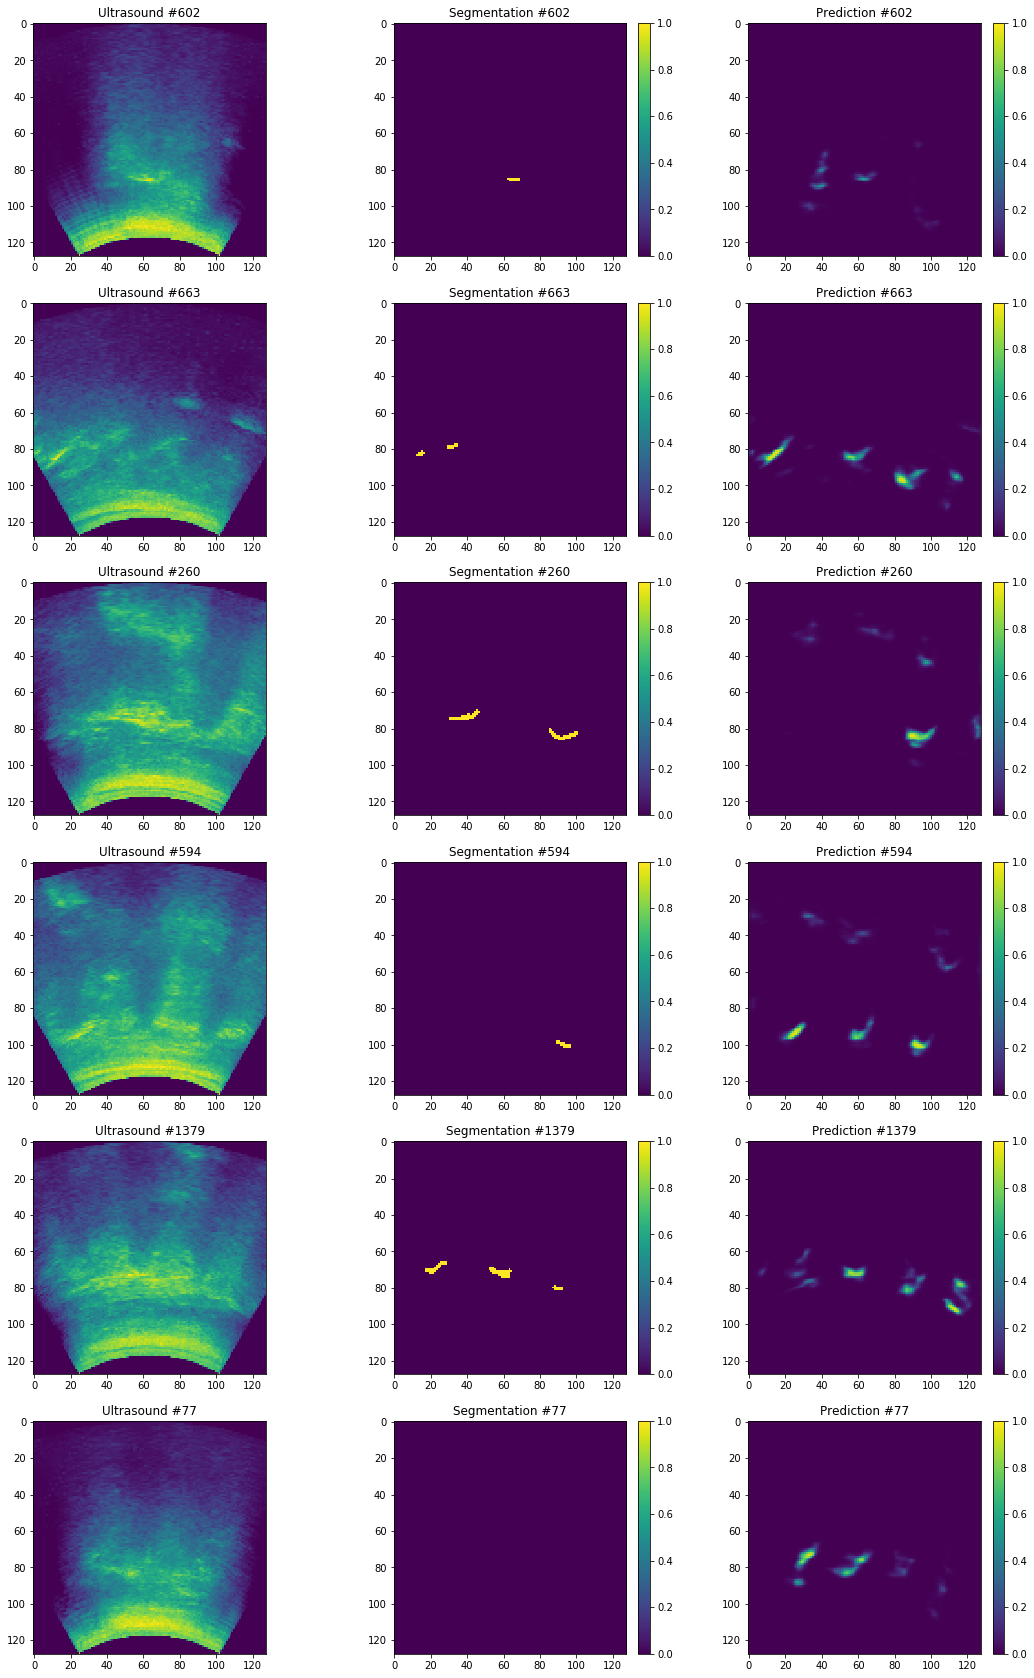

In [12]:
# Display sample results

num_test = test_ultrasound_array.shape[0]
num_show = 6

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_array[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_array[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(test_prediction[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [13]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [15]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + train_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationTest_2019-11-03_15-50-46.html
